In [ ]:
import numpy as np
import pulp
from dataclasses import dataclass
from typing import List, Dict, Tuple
import itertools

@dataclass
class AtomType:
    symbol: str
    charge: float
    A: float
    rho: float
    C: float

@dataclass
class GridSite:
    position: np.ndarray
    fractional_coords: np.ndarray
    site_id: int

class CubicGrid:
    def __init__(self, lattice_param: float, grid_divisions: int):
        self.a = lattice_param
        self.divisions = grid_divisions
        self.spacing = lattice_param / grid_divisions
        self.sites = self._generate_sites()

    def _generate_sites(self) -> List[GridSite]:
        sites = []
        idx = 0
        for i, j, k in itertools.product(range(self.divisions), repeat=3):
            pos = np.array([i, j, k]) * self.spacing
            frac = np.array([i, j, k]) / self.divisions
            sites.append(GridSite(pos, frac, idx))
            idx += 1
        return sites

def buckingham_energy(r, A, rho, C):
    if r == 0:
        return 0
    return A * np.exp(-r / rho) - C / r**6

KE_EV_ANG = 14.3996   # eV·Å / e²
eps_r = 10.0

def ewald_energy(q1, q2, r, epsilon=1e-10):
    if r == 0:
        return 0
    return KE_EV_ANG * q1 * q2 / (eps_r * (r + epsilon))

def compute_interaction_matrix(
        grid: CubicGrid,
        atom_types: Dict[str, AtomType],
        pair_params: Dict[Tuple[str, str], Tuple[float, float, float]],
        r_cutoff: float = 6.0
) -> Dict[Tuple[int, str, int, str], float]:
    """
    construct (i,e1,j,e2) -> energy dictionary,i<j.
    pair_params: {('Sr','O'): (A, rho, C), ...}
    """
    interaction = {}
    n_sites = len(grid.sites)

    
    for i, j in itertools.combinations(range(n_sites), 2):
        r = np.linalg.norm(grid.sites[i].position - grid.sites[j].position)
        if r_cutoff and r > r_cutoff:
            continue  # skip

        for e1 in atom_types:
            for e2 in atom_types:
                # ---- 1. Buckingham  ----
                if (e1, e2) in pair_params:
                    A, rho, C = pair_params[(e1, e2)]
                elif (e2, e1) in pair_params:  # search
                    A, rho, C = pair_params[(e2, e1)]
                else:  # fallback: mean
                    print('Warning!')
                    at1, at2 = atom_types[e1], atom_types[e2]
                    A   = (at1.A   + at2.A)   / 2
                    rho = (at1.rho + at2.rho) / 2
                    C   = (at1.C   + at2.C)   / 2

                # ---- 2. calculate E ----
                e_buck  = buckingham_energy(r, A, rho, C)
                q1, q2  = atom_types[e1].charge, atom_types[e2].charge
                e_ewald = ewald_energy(q1, q2, r)

                interaction[(i, e1, j, e2)] = e_buck + e_ewald
    return interaction


def solve_global_ip(grid: CubicGrid, atom_types: Dict[str, AtomType], composition: Dict[str, int]):
    prob = pulp.LpProblem("Global_CSP", pulp.LpMinimize)
    x = {(i, e): pulp.LpVariable(f"x_{i}_{e}", cat='Binary')
         for i in range(len(grid.sites)) for e in atom_types}

    # One atom per site at most
    for i in range(len(grid.sites)):
        prob += pulp.lpSum(x[(i, e)] for e in atom_types) <= 1

    # Element counts
    for e in composition:
        prob += pulp.lpSum(x[(i, e)] for i in range(len(grid.sites))) == composition[e]

    print('checkpoint 1')
    
    # Interaction matrix
    interaction = interaction = compute_interaction_matrix(grid, atom_types, pair_params, r_cutoff=5.5)

    print('checkpoint 2')
    # Linearize x[i,e1]*x[j,e2] with z vars
    z = {}
    for (i, e1, j, e2), energy in interaction.items():
        if i >= j: continue
        z[(i, e1, j, e2)] = pulp.LpVariable(f"z_{i}_{e1}_{j}_{e2}", cat='Binary')
        prob += z[(i, e1, j, e2)] <= x[(i, e1)]
        prob += z[(i, e1, j, e2)] <= x[(j, e2)]
        prob += z[(i, e1, j, e2)] >= x[(i, e1)] + x[(j, e2)] - 1

    print('checkpoint 3')
    
    # Total energy objective
    prob += pulp.lpSum(interaction[(i, e1, j, e2)] * z[(i, e1, j, e2)]
                       for (i, e1, j, e2) in z)

    print(f"#x={len(grid.sites)*len(atom_types)}, #z={len(z)}")
    print(f"#constraints={len(prob.constraints)}")
    
    solver = pulp.GUROBI(msg=1,
                     TimeLimit=300,   # 5 min
                     MIPFocus=1) 
    prob.solve(solver)
    print('status:', pulp.LpStatus[prob.status])

    print('checkpoint 4')
    
    selected = []
    for (i, e) in x:
        if pulp.value(x[(i, e)]) > 0.5:
            selected.append((e, grid.sites[i].position))
    return selected

# === Parameters ===
lattice_param = 4.0
grid_divisions = 4
composition = {'Sr': 1, 'Ti': 1, 'O': 3}
atom_types: Dict[str, AtomType] = {
    'Sr': AtomType(symbol='Sr', charge=2.0, A=1450.0, rho=0.35, C=0.0),
    'Ti': AtomType(symbol='Ti', charge=4.0, A=1000.0, rho=0.35, C=0.0),
    'O':  AtomType(symbol='O',  charge=-2.0, A=22764.0, rho=0.149, C=27.88)
}
pair_params = {
    ('Sr','O'): (1455.2, 0.3585, 0.0),
    ('Ti','O'): (3147.6, 0.2870, 0.0),
    ('O','O') : (22764.0,0.1490,27.88),
    ('Sr','Sr'): (2386.0,0.3327,0.0),
    ('Ti','Ti'): (2000.0,0.3500,0.0),
    ('Sr','Ti'): (1155.0,0.3560,0.0)
}


# === Execution ===
grid = CubicGrid(lattice_param, grid_divisions)
selected_atoms = solve_global_ip(grid, atom_types, composition)
selected_atoms


checkpoint 1
checkpoint 2
checkpoint 3
#x=192, #z=18144
#constraints=54499


PulpSolverError: GUROBI: Not Available

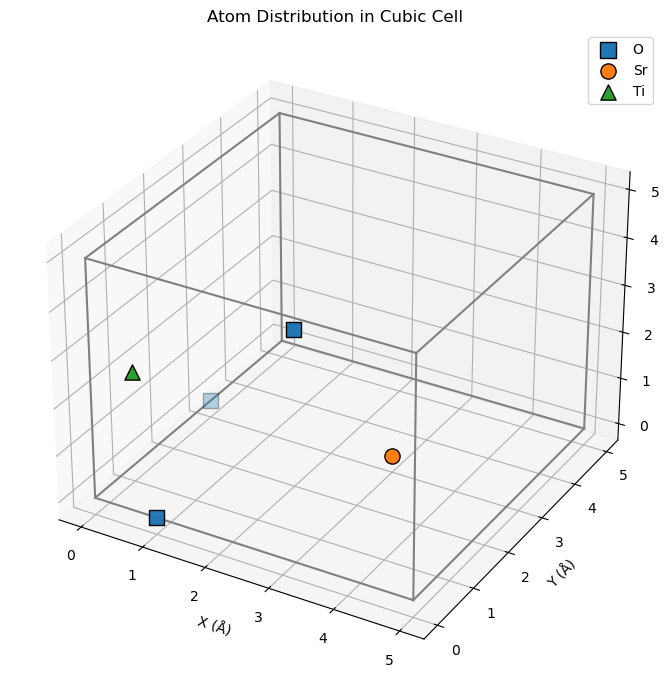

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Expecting that `selected_atoms` has been produced by the solver ===
# selected_atoms is a list of tuples: (element_symbol, np.ndarray([x, y, z]))
# For demonstration, I'll create a dummy list if it doesn't exist.

# Split positions and element labels
chosen_elements = [elem for elem, pos in selected_atoms]
chosen_positions = [pos for elem, pos in selected_atoms]

# === Visualization Parameters ===
lattice_parameter = 5.0   # Update if your solver used a different value
grid_divisions = 4
spacing = lattice_parameter / grid_divisions

# 1. Draw 3D scatter
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

unique_types = sorted(set(chosen_elements))
markers = {'Sr': 'o', 'Ti': '^', 'O': 's'}
for elem in unique_types:
    idxs = [i for i, t in enumerate(chosen_elements) if t == elem]
    pts = np.array([chosen_positions[i] for i in idxs])
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
               label=elem,
               s=120,
               marker=markers.get(elem, 'o'),
               edgecolors='black')

# Draw cube edges
corners_frac = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]])
corners = corners_frac * lattice_parameter
for a in range(8):
    for b in range(a + 1, 8):
        if np.sum(np.abs(corners_frac[a] - corners_frac[b])) == 1:
            p1, p2 = corners[a], corners[b]
            ax.plot(*zip(p1, p2), color='gray')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('Atom Distribution in Cubic Cell')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Atomic coordinates (in lattice parameter a=1)
atoms = {
    'Sr': [(0, 0, 0)],
    'Ti': [(0.5, 0.5, 0.5)],
    'O': [(0.5, 0.5, 0), (0.5, 0, 0.5), (0, 0.5, 0.5)]
}

# colors for different elements
colors = {'Sr': 'blue', 'Ti': 'red', 'O': 'green'}
sizes = {'Sr': 300, 'Ti': 200, 'O': 100}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# draw atoms
for atom_type, coords in atoms.items():
    xs, ys, zs = zip(*coords)
    ax.scatter(xs, ys, zs, color=colors[atom_type], s=sizes[atom_type], label=atom_type)

# draw unit cell edges
def draw_cube(ax):
    cube_lines = [
        [(0, 0, 0), (1, 0, 0)],
        [(0, 0, 0), (0, 1, 0)],
        [(0, 0, 0), (0, 0, 1)],
        [(1, 0, 0), (1, 1, 0)],
        [(1, 0, 0), (1, 0, 1)],
        [(0, 1, 0), (1, 1, 0)],
        [(0, 1, 0), (0, 1, 1)],
        [(0, 0, 1), (1, 0, 1)],
        [(0, 0, 1), (0, 1, 1)],
        [(1, 1, 0), (1, 1, 1)],
        [(0, 1, 1), (1, 1, 1)],
        [(1, 0, 1), (1, 1, 1)]
    ]
    for line in cube_lines:
        x, y, z = zip(*line)
        ax.plot(x, y, z, color='black', linewidth=0.5)

draw_cube(ax)

# draw
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("SrTiO₃ Perovskite Structure")
ax.legend()
plt.tight_layout()
plt.show()
